# Anomalies in RU2020 vote

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('cleaned.csv')
df['turnout'] = df['given']/np.maximum(1, df['nominal'])
df['support'] = df['yes']/np.maximum(1, df['given'])

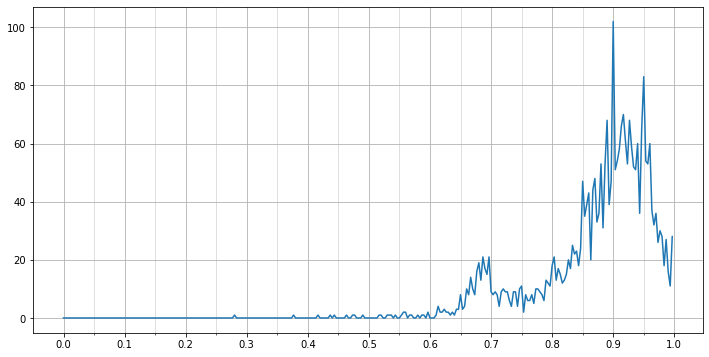

In [3]:
# One region of interest

df1 = df[:][df.region == 'Краснодарский']
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
x = np.histogram(df1['turnout'].values, bins=300, range=(0,1))
plt.plot(x[1][:-1], x[0])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_xticks(np.arange(0,1,0.05), minor=True)
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', alpha=1)

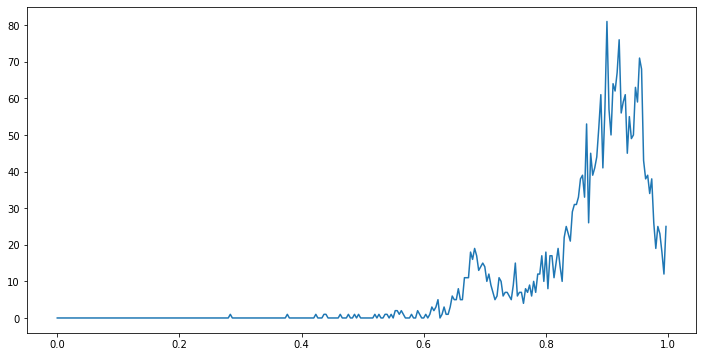

In [4]:
# Noisificator from a diff notebook, not yet functional

def noisify(df1):
    nexp = 1
    sigma = 0.005 # Noisification coefficient
    temp = df1.copy()
    temp['given'] = np.round(temp['nominal']*(temp['turnout']+np.random.normal(size=len(temp))*sigma))
    temp['given'] = np.maximum(0, np.minimum(temp['nominal'], temp['given'])).astype(int)
    temp['yes'] = np.round(temp['given']*(temp['turnout']+np.random.normal(size=len(temp))*sigma))
    temp['yes'] = np.maximum(0, np.minimum(temp['given'], temp['yes'])).astype(int)
    temp['turnout'] = temp.given / temp.nominal
    temp['support'] = temp.yes / temp.given
    return temp

plt.figure(figsize=(12, 6))
x = np.histogram(noisify(df1)['turnout'].values, bins=300, range=(0,1))
plt.plot(x[1][:-1], x[0]);

In [5]:
def measure_comb(vals):
    """For values between 0 and 1, measure how comb-like they are."""
    x = np.histogram(vals, bins=np.arange(0, 1.005, 0.005)-0.002, range=(0,1))
    # This small offset of 0.002 to account for rounding errors around 1%-level values
    return np.sum(x[0][np.arange(50,100)*2])/np.sum(x[0][np.arange(50,100)*2 + 1])
    
print(measure_comb(df1.turnout))

print(np.mean([measure_comb(noisify(df1).turnout) for i in range(1)]))

1.425476603119584
1.0260303687635575


In [6]:
# Summarize by region

ds = df.groupby('region').agg({'turnout': np.mean, 'support': np.mean})
ds.columns = ['turnout', 'support']

regions = np.unique(df.region)
for i in range(len(regions)):
    region = regions[i]
    temp = df[df.region==region]
    ds.loc[region, 'turn_comb'] = (measure_comb(temp.turnout) / 
                                   np.mean([measure_comb(noisify(temp).turnout) for i in range(50)]))
    ds.loc[region, 'supp_comb'] = (measure_comb(temp.support) / 
                                   np.mean([measure_comb(noisify(temp).support) for i in range(50)]))
    print('.', end='')

...................................................................................

In [7]:
print(ds.to_string())

                       turnout   support  turn_comb  supp_comb
region                                                        
Адыгея                0.838148  0.836264   1.229185   1.141647
Алтай                 0.611818  0.689184   0.847605   1.123347
Алтайский             0.585550  0.735957   1.096379   0.929526
Амурская              0.658708  0.718675   1.197309   1.102045
Архангельская         0.578532  0.704881   1.020765   0.879875
Астраханская          0.752808  0.836324   1.249782   1.141701
Башкортостан          0.936022  0.915006   1.424637   1.545269
Белгородская          0.840959  0.828447   1.129571   1.137239
Брянская              0.919751  0.872542   1.351030   1.616768
Бурятия               0.733084  0.753212   1.148656   1.040370
Владимирская          0.568852  0.703858   1.182574   1.078246
Волгоградская         0.814460  0.830883   1.167288   1.312277
Вологодская           0.678866  0.741353   0.970772   0.926547
Воронежская           0.800111  0.814271   1.191202   1

In [9]:
def latinize(s):
    """Latinsca"""
    a1 = 'абвгдежзиклмнопрстуфхцчшщэюяьъый'
    a2 = "a b v g d e zh z i k l m n o p r s t u f h ts ch sh sch e yu ya ' ' y y"
    a1 = a1 + a1.upper()
    a2 = a2 + ' ' + a2.upper()
    a2 = a2.split(' ')
    t = {a1[i]: a2[i] for i in range(len(a1))}
    return ''.join([t[c] if c in t else c for c in s])
    
latinize('Уфа1')

'Ufa1'

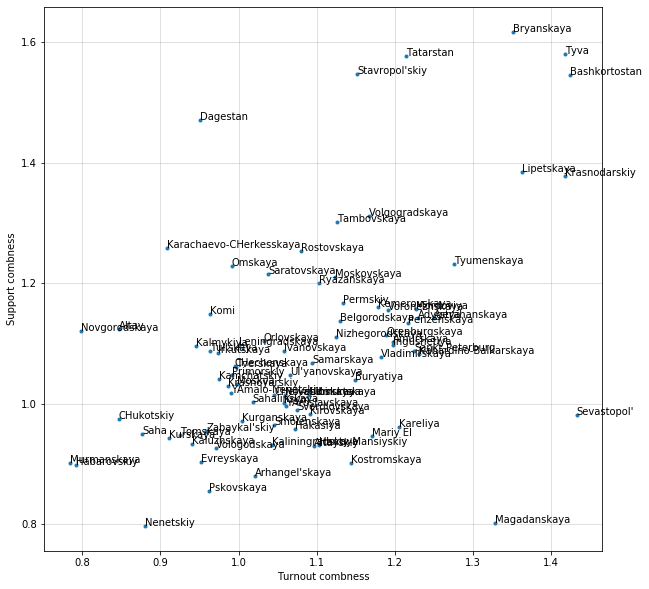

In [10]:
plt.figure(figsize=(10, 10))
plt.plot(ds.turn_comb, ds.supp_comb, '.');
plt.grid(alpha = 0.5)
for i in range(len(ds)):
    plt.text(ds.turn_comb.values[i], ds.supp_comb.values[i], latinize(ds.index.tolist()[i]));
plt.xlabel('Turnout combness');
plt.ylabel('Support combness');

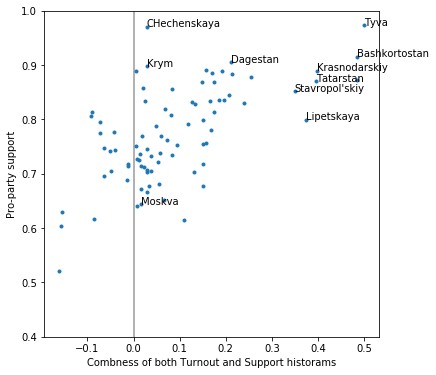

In [28]:
plt.figure(figsize=(6, 6), facecolor='white')
plt.plot((ds.turn_comb.values + ds.supp_comb.values)/2 - 1, ds.support, '.');
plt.xlabel('Combness of both Turnout and Support historams');
plt.ylabel('Pro-party support');
label_these = ['Тыва', 'Чеченская', 'Башкортостан', 'Краснодарский', 'Татарстан', 
               'Дагестан', 'Крым', 'Москва', 'Липецкая', 'Ставропольский']
plt.vlines(0, 0, 1, alpha=0.4)
plt.ylim(0.4, 1)
for i in range(len(ds)):
    if ds.index.tolist()[i] in label_these:
        plt.text((ds.turn_comb.values[i] + ds.supp_comb.values[i])/2 - 1, ds.support[i], 
                  latinize(ds.index.tolist()[i]));